# Hw2 of Digital Image Processing
# Ehsan Ghasemi
# 98102108


## Q1 - Hough Transform


In [74]:
# import our needed libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 10) 

# Define our needed functions -------------------------------
# function for reading an image from its path
def reading_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

# showing an image by matplotlib library
def showing_image(image): 
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.show()

# function for detecting edges
def edge_detection(image, th1=200, th2=500): 
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image_blurred = cv2.GaussianBlur(image_gray, (5, 5), 0)
    image_output = cv2.Canny(image_blurred, th1, th2)
    return image_output

# Hough transform
def hough_tranaform(img, q_level):
    img_width, img_length = img.shape
    r = int(np.ceil((img_width ** 2 + img_length ** 2) ** (1/2)))
    
    # accumulator matrix : -number of lines -x_start -y_start -x_end -y_end
    accumulator_matrix = np.zeros(shape=(r, q_level, 7))              
                                                                      
    # main body : loop over all edge nodes
    for i in range(img_width):
        for j in range(img_length):

            # find all edge nodes
            if img[i, j] > 10: 

                # loop over all quantization levels
                for theta in range(q_level):                       # k means each degree in plane
                    angle = theta/180 * np.pi                      # this is angle base of radient
                    rho = int(i * np.cos(angle) - j * np.sin(angle))
                    accumulator_matrix[rho, theta, 0] += 1

                    # find start and end of each lines
                    if (accumulator_matrix[rho, theta, 1] == 0) & (accumulator_matrix[rho, theta, 2] == 0): 
                        accumulator_matrix[rho, theta, 1] = i
                        accumulator_matrix[rho, theta, 2] = j

                    if (accumulator_matrix[rho, theta, 3] == 0) & (accumulator_matrix[rho, theta, 4] == 0):
                        accumulator_matrix[rho, theta, 3] = i
                        accumulator_matrix[rho, theta, 4] = j

                    if i < accumulator_matrix[rho, theta, 1]:
                        accumulator_matrix[rho, theta, 1] = i
                        accumulator_matrix[rho, theta, 2] = j

                    if i > accumulator_matrix[rho, theta, 3]:
                        accumulator_matrix[rho, theta, 3] = i
                        accumulator_matrix[rho, theta, 4] = j

                    if (i == accumulator_matrix[rho, theta, 1]) & (j < accumulator_matrix[rho, theta, 2]):
                        accumulator_matrix[rho, theta, 1] = i
                        accumulator_matrix[rho, theta, 2] = j

                    if (i == accumulator_matrix[rho, theta, 3]) & (j > accumulator_matrix[rho, theta, 4]):
                        accumulator_matrix[rho, theta, 3] = i
                        accumulator_matrix[rho, theta, 4] = j
                        
                    accumulator_matrix[rho, theta, 5] += i
                    accumulator_matrix[rho, theta, 6] += j 
                    
    return accumulator_matrix

# drawing edges of Hough transform
def drawing_edges(img_input, accumulator_matrix, threshold):
    # find lines with maximum nodes in there
    rho, theta = np.where(accumulator_matrix[:, :, 0] > threshold)
    
    img = img_input.copy()
    # drawing lines
    for i in range(len(rho)):
        p = rho[i]
        angle = theta[i]
        x_start = int(accumulator_matrix[p, angle, 1])
        y_start = int(accumulator_matrix[p, angle, 2])
        x_end = int(accumulator_matrix[p, angle, 3])
        y_end = int(accumulator_matrix[p, angle, 4])    
        cv2.line(img, (y_start, x_start), (y_end, x_end), (0, 255, 0), 3)
    
    return img

# drawing edges of Hough transform just in the game board
def drawing_specefic_edges(img_input, accumulator_matrix, threshold1=80, threshold2=80, th_error=5, dis_error=5, chessboard_len1=5, chessboard_len2=5, node_flag=False):
    # find lines with maximum nodes in there
    rho, theta = np.where(accumulator_matrix[:, :, 0] > np.min((threshold1, threshold2)))
    v = accumulator_matrix[rho, theta, 0]
    
    # creating an array including p, theta and value of each lines
    result = np.concatenate((rho.reshape(-1, 1), theta.reshape(-1, 1), v.reshape(-1, 1)), axis=1)
    result = result[result[:, 2].argsort()[::-1]]
    
    # define theta of each specefic lines
    theta_list = list(result[:, 1])
    thr = np.min((10, len(theta_list)))
    theta_list = theta_list[:thr]
    theta_list = sorted(theta_list, key=lambda x: theta_list.count(x), reverse=True)
    
    list1_th = theta_list[0]
    for i in range(len(theta_list)):
        th = theta_list[i] 
        if (th > list1_th + 10) | (th < list1_th - 10):
            list2_th = th
            break
    

    # analyzing all lines and keep just specefic ones
    list1 = []
    list2 = []
    for i in range(np.min((result.shape[0], 500))):
        p = result[i, 0]
        th = result[i, 1] 
        v = result[i, 2]
        if (th > list1_th - th_error) & (th < list1_th + th_error):
            help_arr = np.array(list1)
            my_flag = np.any((help_arr > p - 5) & (help_arr < p + 5))
            if not my_flag: 
                list1.append(p)
            
        elif (th > list2_th - th_error) & (th < list2_th + th_error):
            help_arr = np.array(list2)
            my_flag = np.any((help_arr > p - 5) & (help_arr < p + 5))
            if not my_flag: 
                list2.append(p)
    
#     print('len list1 : ', len(list1))
#     print('len list2 : ', len(list2))
    
    # exclude distance of lines in the board game
    line_th1 = np.min((7, len(list1)))
    line_th2 = np.min((7, len(list2)))
    list1 = list1[:line_th1]
    list2 = list2[:line_th2]

    list1 = sorted(list1, reverse=True)
    list2 = sorted(list2, reverse=True)

    list1_d = []
    list2_d = []
    
#     print('list1 : ', list1)
#     print('list2 : ', list2)
    
    for i in range(line_th1-1):
        list1_d.append(list1[i] - list1[i+1])
        
    for i in range(line_th2-1):
        list2_d.append(list2[i] - list2[i+1])

    list1_d = sorted(list1_d, key=lambda x: list1_d.count(x), reverse=True)
    list2_d = sorted(list2_d, key=lambda x: list2_d.count(x), reverse=True)


    list1_dis = list1_d[0]
    list2_dis = list2_d[0]
    

    # exclude a line with a valid p 
    for i in range(line_th1-1):
        dis = list1[i] - list1[i+1]
        if (dis > list1_dis - dis_error) & (dis < list1_dis + dis_error):
            list1_vp = list1[i]

            
    for i in range(line_th2-1):
        dis = list2[i] - list2[i+1]
        if (dis > list2_dis - dis_error) & (dis < list2_dis + dis_error):
            list2_vp = list2[i] 
        
        
        
#     print('list1 th : ', list1_th)
#     print('list2 th : ', list2_th)
#     print('list1 vp : ', list1_vp)
#     print('list2 vp : ', list2_vp)
#     print('list1 d : ', list1_dis)
#     print('list2 d : ', list2_dis)
    
    
    
    list1_line_counter = np.ones(shape = (2 * chessboard_len1 + 1, 1))
    list2_line_counter = np.ones(shape = (2 * chessboard_len2 + 1, 1))
    
    # drawing our specefic lines
    img = img_input.copy()
    # drawing lines
    
    node_lists1 = []
    node_lists2 = []
    for i in range(np.min((len(rho)))):
        p = int(result[i, 0])
        angle = int(result[i, 1])
        vo = result[i, 2] 
        
        # check for lines just in the game board
        case1_angle = (angle > list1_th - th_error) & (angle < list1_th + th_error)
        case1_p = np.abs(p - list1_vp) % list1_dis 
        case1_p = (case1_p <= dis_error) | (case1_p >= list1_dis - dis_error)
        
        case1_count = np.max((np.abs(p + dis_error - list1_vp), np.abs(p - dis_error - list1_vp)))
        case1_count = np.floor(case1_count / list1_dis) * np.sign(p - list1_vp)
        counter1 = case1_count.copy()
        if np.abs(case1_count) < chessboard_len1: 
            case1_count = list1_line_counter[int(case1_count) + chessboard_len1, 0]
        else:
            case1_count = 0
        case1_count = case1_count > 0 

        case1_vo = vo > threshold1
        

        case2_angle = (angle > list2_th - th_error) & (angle < list2_th + th_error)
        case2_p = np.abs(p - list2_vp) % list2_dis 
        case2_p = (case2_p <= dis_error) | (case2_p >= list2_dis - dis_error)
        
        
        case2_count = np.max((np.abs(p + dis_error - list2_vp), np.abs(p - dis_error - list2_vp)))
        case2_count = np.floor(case2_count / list2_dis) * np.sign(p - list2_vp)
        counter2 = case2_count.copy()
        if np.abs(case2_count) < chessboard_len2: 
            case2_count = list2_line_counter[int(case2_count) + chessboard_len2, 0]
        else:
            case2_count = 0
        case2_count = case2_count > 0 
        
        case2_vo = vo > threshold2

        
        
        if (case1_angle & case1_p & case1_count & case1_vo):
            theta = angle * np.pi / 180 
            line_len = int(accumulator_matrix[p, angle, 0])
            x_center = int(accumulator_matrix[p, angle, 5] / line_len)
            y_center = int(accumulator_matrix[p, angle, 6] / line_len)
            
            line_len = 2000
            x_start = int(x_center - line_len / 2 * np.sin(theta))
            y_start = int(y_center - line_len / 2 * np.cos(theta))
            x_end = int(x_center + line_len / 2 * np.sin(theta))
            y_end = int(y_center + line_len / 2 * np.cos(theta)) 
            
            x_start = int(accumulator_matrix[p, angle, 1])
            y_start = int(accumulator_matrix[p, angle, 2])
            x_end = int(accumulator_matrix[p, angle, 3])
            y_end = int(accumulator_matrix[p, angle, 4])
            
            list1_line_counter[int(counter1) + chessboard_len1, 0] -= 1
            cv2.line(img, (y_start, x_start), (y_end, x_end), (0, 255, 0), 3)
#             print('x center : ', x_center)
#             print('y center : ', y_center)
#             print('case1 count : ', counter1)
#             print('p : ', p)
#             print('angle : ', angle)
#             print('vo : ', vo)
#             print('-----------------------')

            node_lists1.append((y_start, x_start, y_end, x_end))




        if (case2_angle & case2_p & case2_count & case2_vo):
            theta = angle * np.pi / 180 
            line_len = int(accumulator_matrix[p, angle, 0])
            x_center = int(accumulator_matrix[p, angle, 5] / line_len)
            y_center = int(accumulator_matrix[p, angle, 6] / line_len)
            
            line_len = 2500
            x_start = int(x_center - line_len / 2 * np.sin(theta))
            y_start = int(y_center - line_len / 2 * np.cos(theta))
            x_end = int(x_center + line_len / 2 * np.sin(theta))
            y_end = int(y_center + line_len / 2 * np.cos(theta)) 
            list2_line_counter[int(counter2) + chessboard_len2, 0] -= 1
            
            x_start = int(accumulator_matrix[p, angle, 1])
            y_start = int(accumulator_matrix[p, angle, 2])
            x_end = int(accumulator_matrix[p, angle, 3])
            y_end = int(accumulator_matrix[p, angle, 4])
            
            cv2.line(img, (y_start, x_start), (y_end, x_end), (0, 255, 0), 3)
#             print('case1 count : ', counter2)
#             print('p : ', p)
#             print('angle : ', angle)
#             print('vo : ', vo)
#             print('-----------------------')
            
            node_lists2.append((y_start, x_start, y_end, x_end))
        
        if node_flag:
            for node1 in node_lists1:
                for node2 in node_lists2:
                    a1 = (node1[0] - node1[2]) / (node1[1] - node1[3])
                    a2 = (node2[0] - node2[2]) / (node2[1] - node2[3])
                    
                    b1 = node1[0] - a1 * node1[1]
                    b2 = node2[0] - a2 * node2[1]
                    
                    x_common = int((b2 - b1) / (a1 - a2))
                    y_common = int(a1 * x_common + b1)
                    
                    cv2.circle(img, (y_common, x_common), 5, (255, 0, 0), -1)
            
            
    
    return img
# -----------------------------------------------------------

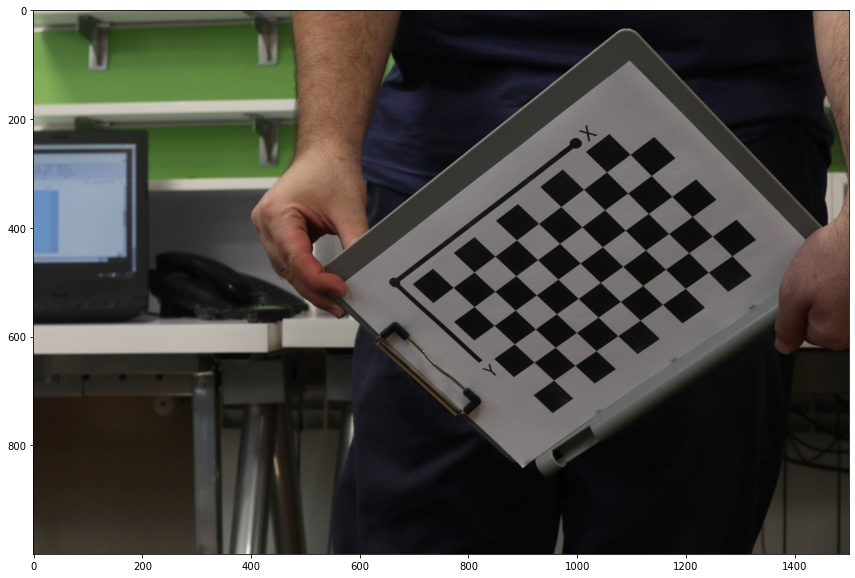

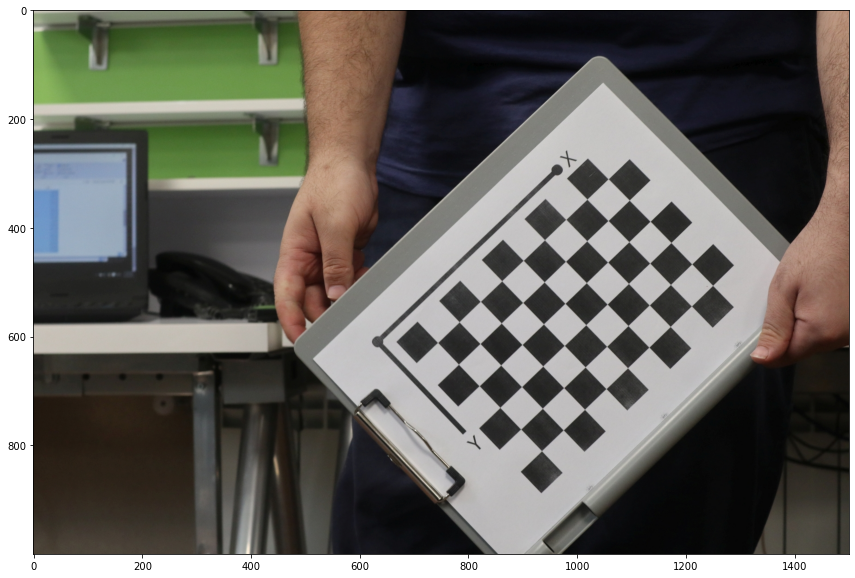

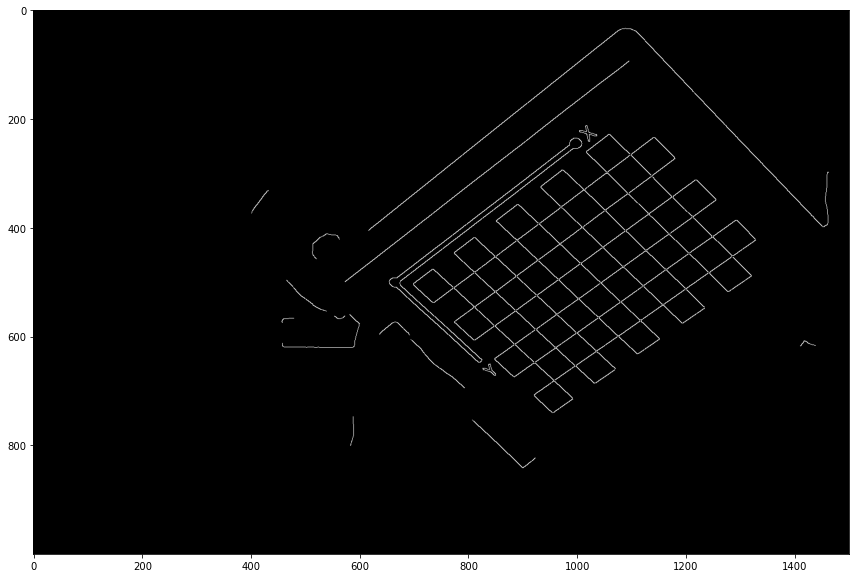

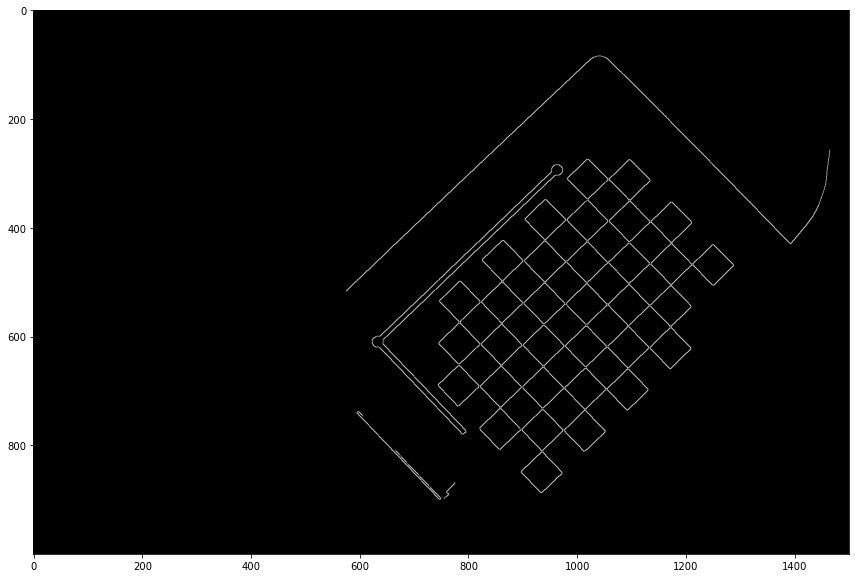

True

In [68]:
# Reading our images
image1 = reading_image("Checker1.jpg")
image2 = reading_image("Checker2.jpg")

# Showing our images 
showing_image(image1)
showing_image(image2)

# # step 1: Edge detection
image1_edge_detected = edge_detection(image1, 180, 300)
image2_edge_detected = edge_detection(image2)
showing_image(image1_edge_detected)
showing_image(image2_edge_detected)

# saving our edge dectected form of our images
cv2.imwrite('result01.jpg', image1_edge_detected)
cv2.imwrite('result02.jpg', image2_edge_detected)

In [69]:
# # Hough transform
accumulator_matrix1 = hough_tranaform(image1_edge_detected, 180)
accumulator_matrix2 = hough_tranaform(image2_edge_detected, 180)

# saving our accumulator matrixes
result03 = accumulator_matrix1[:, :, 0].copy()
result04 = accumulator_matrix2[:, :, 0].copy()
cv2.imwrite('result03_Hough_space.jpg', result03)
cv2.imwrite('result04_Hough_space.jpg', result04)

True

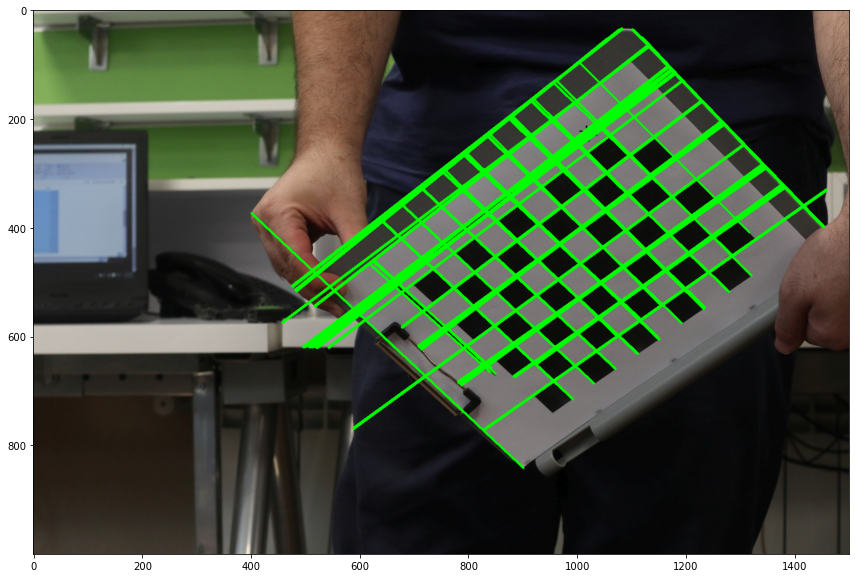

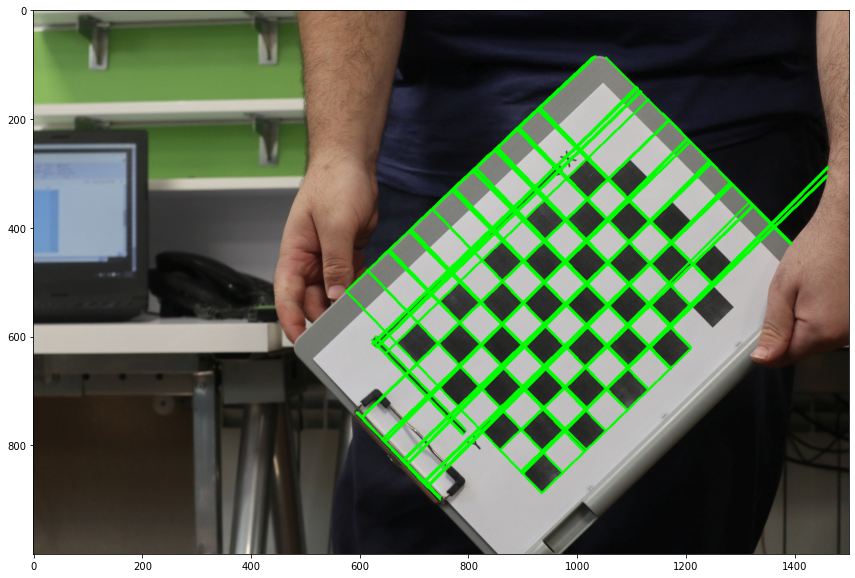

True

In [70]:
# drawing lines of results
img_output1 = drawing_edges(image1, accumulator_matrix1, 128)
img_output2 = drawing_edges(image2, accumulator_matrix2, 128)

# showing the result image
showing_image(img_output1)
showing_image(img_output2)

# saving our images
result05 = cv2.cvtColor(img_output1, cv2.COLOR_RGB2BGR)
result06 = cv2.cvtColor(img_output2, cv2.COLOR_RGB2BGR)
cv2.imwrite('result05_Lines.jpg', result05)
cv2.imwrite('result06_Lines.jpg', result06)

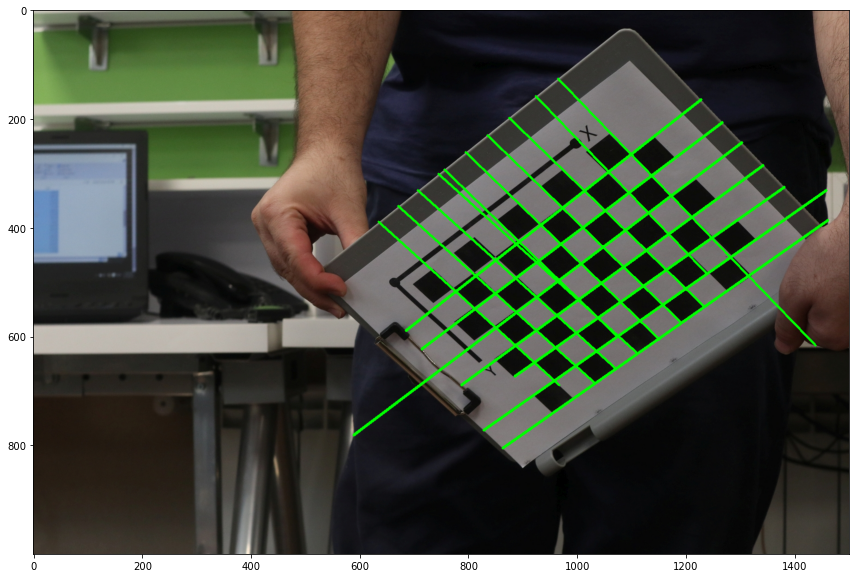

True

In [71]:
# drawing just the chessboard game edges
img_output1 = drawing_specefic_edges(image1, accumulator_matrix1, 80, 80, 5, 6, 4, 7)

# # showing the result image
showing_image(img_output1)

# saving the results
result07 = cv2.cvtColor(img_output1, cv2.COLOR_RGB2BGR)
cv2.imwrite('result07_chess.jpg', result07)

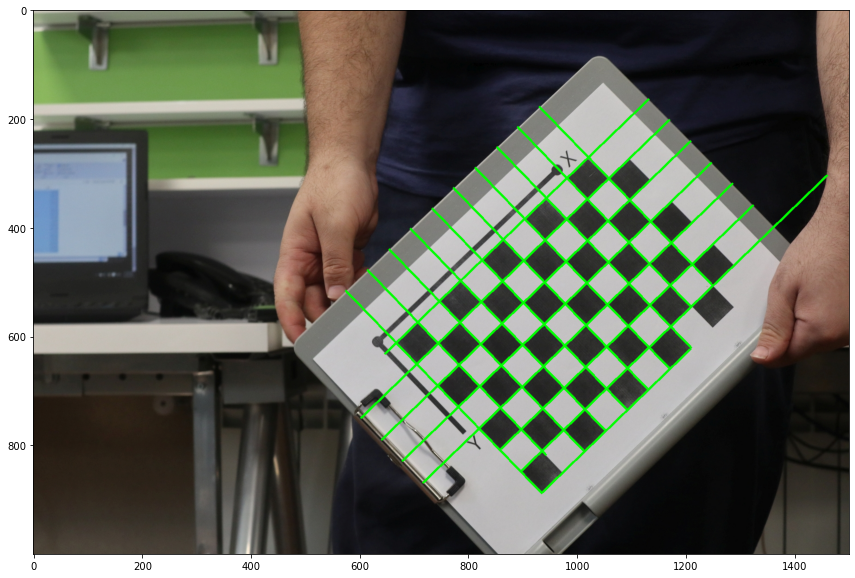

True

In [72]:
# drawing just the chessboard game edges
img_output2 = drawing_specefic_edges(image2, accumulator_matrix2, 50, 50, 2, 2, 8, 8)

# # showing the result image
showing_image(img_output2)

# saving the result
result08 = cv2.cvtColor(img_output2, cv2.COLOR_RGB2BGR)
cv2.imwrite('result08_chess.jpg', result08)

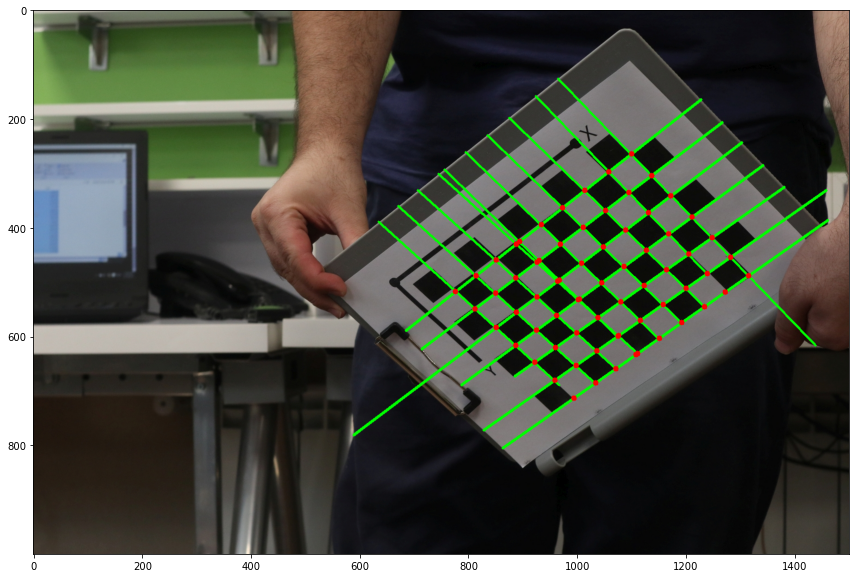

True

In [77]:
# drawing just the chessboard game edges
img_output1 = drawing_specefic_edges(image1, accumulator_matrix1, 80, 80, 5, 6, 4, 7, True)

# # showing the result image
showing_image(img_output1)

# # saving the results
result09 = cv2.cvtColor(img_output1, cv2.COLOR_RGB2BGR)
cv2.imwrite('result09_corners.jpg', result09)

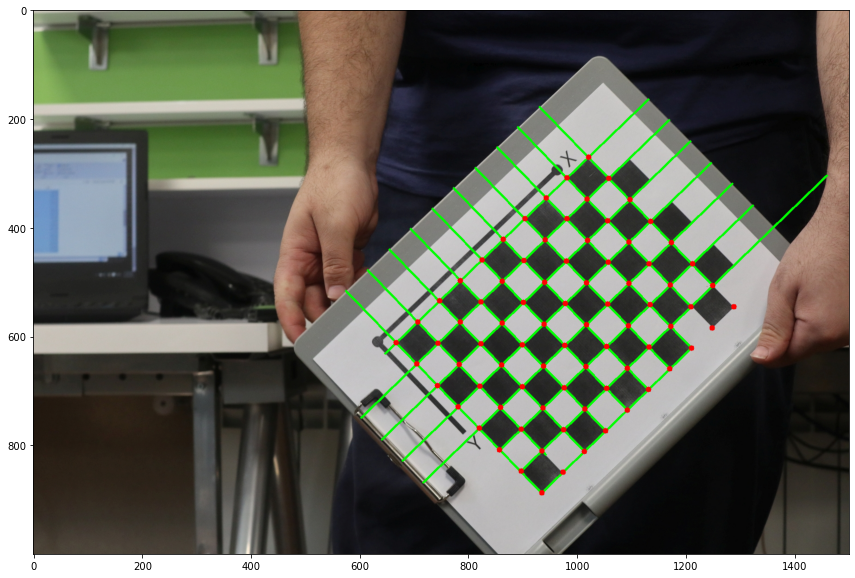

True

In [79]:
# drawing just the chessboard game edges
img_output2 = drawing_specefic_edges(image2, accumulator_matrix2, 50, 50, 2, 2, 8, 8, True)

# # showing the result image
showing_image(img_output2)

# saving the result
result10 = cv2.cvtColor(img_output2, cv2.COLOR_RGB2BGR)
cv2.imwrite('result10_corners.jpg', result10)